In [126]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

In [127]:
# Set random seed for reproducibility
torch.manual_seed(7)  # Set the seed for generating random numbers in PyTorch
np.random.seed(7)     # Set the seed for generating random numbers in NumPy

In [128]:
# Define Hyper Parameters

hidden_size = 256
num_classes = 7
num_epochs = 2
batch_size = 4
learning_rate = 0.001
num_layers = 2


# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [129]:
xy =  np.loadtxt('./result.csv',delimiter=',',dtype=np.float32)
X = xy[:,1:] # Indexes inputs
y = xy[:,0] # Indexes Labels

sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)

# Random State So it is reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [130]:
# Creates TrainCoinDataSet
class TrainCoinDataSet(Dataset):

    def __init__(self, X_train, y_train):
        # Data Loading
        self.x = torch.from_numpy(X_train.astype(np.float32))
        self.y = torch.from_numpy(y_train).type(torch.LongTensor)
        self.n_samples = y_train.shape[0] # n_samples
        print(self.n_samples)

    def __getitem__(self, index):
        # Allows indexing
        return self.x[index], self.y[index]

    def __len__(self):
        # Allows calling length
        return self.n_samples
    
class TestCoinDataSet(Dataset):

    def __init__(self, X_test, y_test):
        # Data Loading
        self.x = torch.from_numpy(X_test.astype(np.float32))
        self.y = torch.from_numpy(y_test).type(torch.LongTensor)
        self.n_samples = y_test.shape[0] # n_samples
        print(self.n_samples)

    def __getitem__(self, index):
        # Allows indexing
        return self.x[index], self.y[index]

    def __len__(self):
        # Allows calling length
        return self.n_samples

In [131]:
# Creates Dataset
train_data = TrainCoinDataSet(X_train, y_train)
test_data = TestCoinDataSet(X_test, y_test)

# Defines Train and Test Datasets sizes
#train_size = int(0.8 * len(dataset))  # 80% of the data will be used for training
#test_size = len(dataset) - train_size  # Remaining 20% will be used for test

# Split dataset into training set and test set
#train_data, test_data = random_split(dataset, [train_size, test_size])

# Creates Dataloaders for train and test datasets
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)


875
219


In [139]:
print(f'Input shape: {samples.shape} , Labels shape: {labels.shape}')
print(f"Input range after standardization: Min = {samples[0].min()}, Max = {samples[0].max()}")
print(f'Input dtype: {samples[0,0].dtype}')
print(f'Label dtype: {labels[0].dtype}')

Input shape: torch.Size([4, 769024]) , Labels shape: torch.Size([3])
Input range after standardization: Min = 0.0, Max = 1.0000001192092896
Input dtype: torch.float32
Label dtype: torch.int64


In [133]:
# 128 x 6008 = 769024
input_size = 751
sequence_length = 1024

In [134]:
# Create Model

# Model 
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # x -> (batch_size, seq, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0,c0))
        # out: batch_size, seq_length, hidden_size
        # out (N, 6008, 128)
        # : all samples in batch, -1 last time step, : all features in hidden size
        out = out[:, -1, :] 
        # out (N, 128)
        out = self.fc(out)
        return out

In [135]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [136]:
print(model)

LSTM(
  (lstm): LSTM(751, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)


epoch 1 / 2, step 2/219, loss = 1.8155
epoch 1 / 2, step 4/219, loss = 2.1726
epoch 1 / 2, step 6/219, loss = 1.9425
epoch 1 / 2, step 8/219, loss = 1.7467
epoch 1 / 2, step 10/219, loss = 2.1292
epoch 1 / 2, step 12/219, loss = 2.4281
epoch 1 / 2, step 14/219, loss = 2.1901
epoch 1 / 2, step 16/219, loss = 1.8311
epoch 1 / 2, step 18/219, loss = 1.9057
epoch 1 / 2, step 20/219, loss = 2.0360
epoch 1 / 2, step 22/219, loss = 1.8319
epoch 1 / 2, step 24/219, loss = 2.0228
epoch 1 / 2, step 26/219, loss = 1.5002
epoch 1 / 2, step 28/219, loss = 1.3675
epoch 1 / 2, step 30/219, loss = 1.8608
epoch 1 / 2, step 32/219, loss = 2.1706
epoch 1 / 2, step 34/219, loss = 1.2528
epoch 1 / 2, step 36/219, loss = 1.9206
epoch 1 / 2, step 38/219, loss = 1.7643
epoch 1 / 2, step 40/219, loss = 1.8334
epoch 1 / 2, step 42/219, loss = 1.8058
epoch 1 / 2, step 44/219, loss = 1.5609
epoch 1 / 2, step 46/219, loss = 1.5029
epoch 1 / 2, step 48/219, loss = 1.8547
epoch 1 / 2, step 50/219, loss = 2.0518
epoc

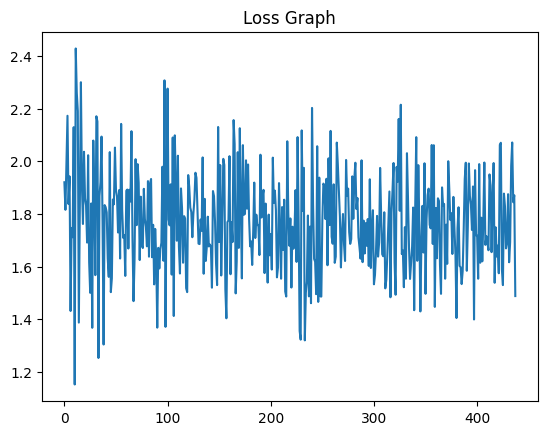

In [137]:
# Training loop

n_total_steps = len(train_loader)
plot_steps, print_steps = 1,2
current_loss = 0.0
all_losses = []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        current_loss += loss.item()

        if (i+1) % plot_steps == 0:
            all_losses.append(current_loss / plot_steps)
            current_loss = 0

        if (i+1) % print_steps == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

plt.figure()
plt.title("Loss Graph")
plt.plot(all_losses)
plt.show()

In [138]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i, (inputs, labels) in enumerate(test_loader):

        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        
        #print(f'input: {i}')
        #print(inputs[0,0])
        labels = labels.to(device)
        print(labels)
        outputs = model(inputs)
        #print(outputs.shape)

        # value, index
        _, predictions = torch.max(outputs, 1)
        print(predictions)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    
    acc = 100 * n_correct / n_samples
    print(f'accuracy = {acc}')

tensor([4, 0, 4, 6])
tensor([5, 5, 5, 5])
tensor([5, 6, 3, 1])
tensor([5, 5, 5, 5])
tensor([1, 0, 3, 6])
tensor([5, 5, 5, 5])
tensor([4, 0, 4, 6])
tensor([5, 5, 5, 5])
tensor([0, 6, 6, 5])
tensor([5, 5, 5, 5])
tensor([3, 3, 5, 3])
tensor([5, 5, 5, 5])
tensor([1, 4, 5, 4])
tensor([5, 5, 5, 5])
tensor([6, 1, 1, 6])
tensor([5, 5, 5, 5])
tensor([4, 5, 0, 5])
tensor([5, 5, 5, 5])
tensor([4, 5, 5, 5])
tensor([5, 5, 5, 5])
tensor([6, 4, 6, 3])
tensor([5, 5, 5, 5])
tensor([4, 0, 4, 6])
tensor([5, 5, 5, 5])
tensor([5, 5, 6, 3])
tensor([5, 5, 5, 5])
tensor([0, 5, 6, 5])
tensor([5, 5, 5, 5])
tensor([3, 5, 5, 5])
tensor([5, 5, 5, 5])
tensor([0, 5, 5, 5])
tensor([5, 5, 5, 5])
tensor([4, 4, 3, 5])
tensor([5, 5, 5, 5])
tensor([1, 0, 3, 6])
tensor([5, 5, 5, 5])
tensor([5, 5, 0, 5])
tensor([5, 5, 5, 5])
tensor([0, 5, 1, 1])
tensor([5, 5, 5, 5])
tensor([6, 6, 1, 0])
tensor([5, 5, 5, 5])
tensor([1, 0, 5, 3])
tensor([5, 5, 5, 5])
tensor([0, 1, 6, 0])
tensor([5, 5, 5, 5])
tensor([5, 6, 6, 6])
tensor([5, 5,